In [1]:
# import libraries
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import xarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data

import glob # for listing files in tiff conversion function
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx

In [2]:
from pathlib import Path
#plotting imports
import matplotlib as mpl
plt.style.use(['seaborn-notebook'])

# unique imports
import s3fs #access data from the AWS s3 bucket

In [3]:
import datetime
#database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas

In [4]:
# Uses AWS credentials on machine
fs = s3fs.S3FileSystem() 

# which data bucket?
bucket = 'snowex-data'  
      
# contents inside /depths     
flist = fs.ls(f'{bucket}/tutorial-data/core-datasets/depths') 

# show list of files
print('File list is: ', flist)

File list is:  ['snowex-data/tutorial-data/core-datasets/depths/SnowEx2020_SnowDepths_COGM_alldepths_v01.csv']


In [5]:
# open depth data file, and create pandas dataframe
with fs.open(flist[0], 'rb') as f: 
    
    df = pd.read_csv(f, sep=',', header=0, parse_dates=[[2,3]]) #parse the date[2] and time[3] columns such that they are read in as datetime dtypes
    
print('file has been read, and is ready to use.')

file has been read, and is ready to use.


In [6]:
# rename some columns for ease further down
df.rename(columns = {
    'Measurement Tool (MP = Magnaprobe; M2 = Mesa 2; PR = Pit Ruler)':'Measurement Tool', 
    'Date (yyyymmdd)_Time (hh:mm, local, MST)': "Datetime"},
          inplace = True)

# set up filter for IOP date range
start = pd.to_datetime('1/28/2020') #first day of GM IOP campaign
end   = pd.to_datetime('2/12/2020') #last day of GM IOP campaign

# filter the IOP date range
df = df[(df['Datetime'] >= start) & (df['Datetime'] <= end)]

print('DataFrame shape is: ', df.shape)
df.head()

DataFrame shape is:  (36388, 12)


Datetime Measurement Tool      ID PitID  Longitude  Latitude  \
0 2020-01-28 11:48:00               MP  100000  8N58 -108.13515  39.03045   
1 2020-01-28 11:48:00               MP  100001  8N58 -108.13516  39.03045   
2 2020-01-28 11:48:00               MP  100002  8N58 -108.13517  39.03045   
3 2020-01-28 11:48:00               MP  100003  8N58 -108.13519  39.03044   
4 2020-01-28 11:48:00               MP  100004  8N58 -108.13519  39.03042   

     Easting    Northing  Depth (cm)  elevation (m) equipment  Version Number  
0  747987.62  4324061.71          94         3148.2   CRREL_B               1  
1  747986.75  4324061.68          74         3148.3   CRREL_B               1  
2  747985.89  4324061.65          90         3148.2   CRREL_B               1  
3  747984.19  4324060.49          87         3148.6   CRREL_B               1  
4  747984.26  4324058.27          90         3150.1   CRREL_B               1

In [7]:
os.chdir('/tmp')

!aws s3 cp --no-progress s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_003_274_0011d/ .  --recursive --exclude "*" --include "*.unw.grd.tif"

download: s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_003_274_0011d/grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.unw.grd.tif to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090VV_01.unw.grd.tif
download: s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_003_274_0011d/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tif to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tif
download: s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_003_274_0011d/grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.unw.grd.tif to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090VH_01.unw.grd.tif
download: s3://snowex-data/uavsar-project/UAVSAR_images/grmesa_2020_003_274_0011d/grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.unw.grd.tif to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HV_01.unw.grd.tif


In [8]:
for unwhh in glob.glob("*HH_01.unw.grd.tif"):
    print(unwhh)

grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tif


In [9]:
unwhh_rast = rio.open(unwhh)
meta_data = unwhh_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7014, 'height': 4768, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -108.30355248000001,
       0.0, -5.556e-05, 39.19030164), 'tiled': False, 'interleave': 'band'}


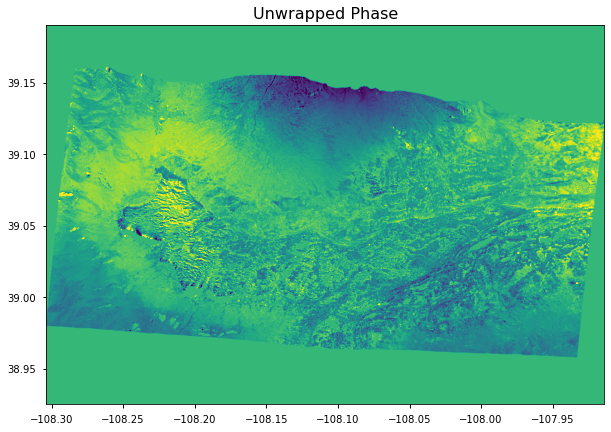

<AxesSubplot:title={'center':'Unwrapped Phase'}>

In [10]:
unw_rast = rio.open(unwhh)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Unwrapped Phase",fontsize = 16);
show((unw_rast, 1), cmap = 'viridis', vmin = -3, vmax = 1.5)

In [ ]:
print(glob.glob("/tmp/*.*"))

In [11]:
data_folder = '/tmp/grmesa_27416_21021_005_210322_L090_CX_01' # if doesn't exist, run scripts/incidence.ipynb first
inc_tiff_file = os.path.join(data_folder, os.path.basename(data_folder) + '.inc.tiff')

In [12]:
# from reproject_match() documentation
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [13]:
xds_unwhh = xarray.open_rasterio(unwhh)
xds_inc = xarray.open_rasterio(inc_tiff_file)
xds_unwhh = xds_unwhh.where(xds_unwhh!=0)
xds_inc = xds_inc.where(xds_inc!=-10000)

In [14]:
print("Original Raster:\n----------------\n")
print_raster(xds_inc)
print("Raster to Match:\n----------------\n")
print_raster(xds_unwhh)

Original Raster:
----------------

shape: (4163, 8949)
resolution: (5.556e-05, -5.556e-05)
bounds: (-108.37516932000001, 38.94833784, -107.87796288000001, 39.17963412)
sum: 25668968.0
CRS: EPSG:4326

Raster to Match:
----------------

shape: (4768, 7014)
resolution: (5.556e-05, -5.556e-05)
bounds: (-108.30355248000001, 38.92539156, -107.91385464000001, 39.19030164)
sum: -6537910.0
CRS: EPSG:4326



In [15]:
xds_inc_repr_match = xds_inc.rio.reproject_match(xds_unwhh)

In [16]:
print("Original Raster:\n----------------\n")
print_raster(xds_inc)
print("Raster to Match:\n----------------\n")
print_raster(xds_unwhh)

Original Raster:
----------------

shape: (4163, 8949)
resolution: (5.556e-05, -5.556e-05)
bounds: (-108.37516932000001, 38.94833784, -107.87796288000001, 39.17963412)
sum: 25668968.0
CRS: EPSG:4326

Raster to Match:
----------------

shape: (4768, 7014)
resolution: (5.556e-05, -5.556e-05)
bounds: (-108.30355248000001, 38.92539156, -107.91385464000001, 39.19030164)
sum: -6537910.0
CRS: EPSG:4326



In [17]:
xds_inc_repr_match = xds_inc_repr_match.assign_coords({
    "x": xds_unwhh.x,
    "y": xds_unwhh.y,
})

In [18]:
wavelength = 0.2379 # m
rho = 0.15 # ?
epsilon = 1 + 1.6*rho + 1.86*rho**3

In [19]:
xds_delta_depth_hh = -1*(xds_unwhh*wavelength)/(4*np.pi*(np.cos(xds_inc_repr_match)-np.sqrt(epsilon-np.sin(xds_inc_repr_match)**2)))

In [20]:
xds_delta_depth_hh.rio.crs

CRS.from_epsg(4326)

In [21]:
xds_delta_depth_hh_re=xds_delta_depth_hh.rio.reproject('EPSG:26912')

In [22]:
xds_delta_depth_hh_re.rio.crs

CRS.from_epsg(26912)

In [23]:
xds_delta_depth_hh

<xarray.DataArray (band: 1, y: 4768, x: 7014)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 39.19 39.19 39.19 39.19 ... 38.93 38.93 38.93 38.93
  * x            (x) float64 -108.3 -108.3 -108.3 ... -107.9 -107.9 -107.9
    spatial_ref  int64 0

Text(0.5, 1.0, 'Change in Depth (meters) HH polarization')

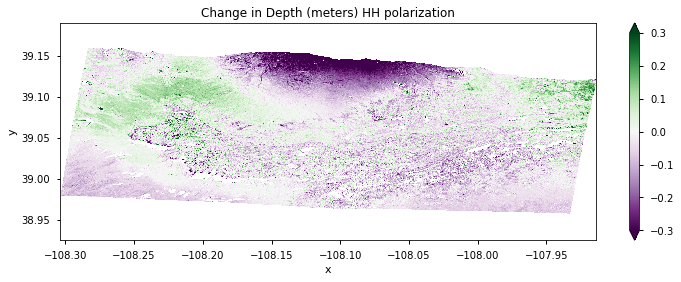

In [24]:
fig, axes = plt.subplots(figsize=(12,4))
xds_delta_depth_hh.plot(ax=axes,vmin=-0.3,vmax=0.3,cmap='PRGn')
axes.set_title('Change in Depth (meters) HH polarization')

Text(0.5, 1.0, 'Change in Depth (meters) HH polarization Reprojected')

/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/colors.py:1202: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


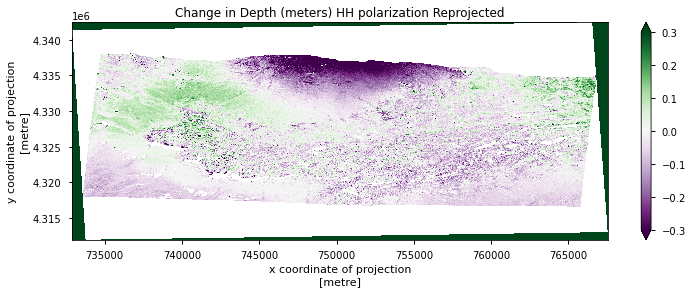

In [25]:
fig, axes = plt.subplots(figsize=(12,4))
xds_delta_depth_hh_re.plot(ax=axes,vmin=-0.3,vmax=0.3,cmap='PRGn')
axes.set_title('Change in Depth (meters) HH polarization Reprojected')

In [26]:
# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [ ]:
# Form the query to receive date='2020-02-01' from the sites table
qry = session.query(SiteData).filter_by(date='2020-02-01')

# Convert the record received into a geopandas dataframe
siteData_df = query_to_geopandas(qry, engine)

# Preview the resulting geopandas dataframe
siteData_df

In [27]:
# Form the query to receive site_id='2S10' from the sites table
qry = session.query(SiteData).filter_by(site_id='5S21')

# Convert the record received into a geopandas dataframe
siteData_df = query_to_geopandas(qry, engine)

# Preview the resulting geopandas dataframe
siteData_df

site_name        date                     time_created time_updated  id  \
0  Grand Mesa  2020-02-01 2021-06-01 18:41:44.242179+00:00         None   1   

  site_id                                   doi date_accessed   latitude  \
0    5S21  https://doi.org/10.5067/DUD2VZEVBJ7S          None  39.019348   

    longitude  ...  weather_description  precip                 sky_cover  \
0 -108.175169  ...        Thin overcast    None  Overcast(complete cover)   

    wind ground_condition ground_roughness  ground_vegetation  \
0  Light           Frozen           Smooth              Grass   

  vegetation_height  tree_canopy  site_notes  
0                10     No Trees        None  

[1 rows x 30 columns]

In [28]:
siteData_df.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan.  United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [29]:
siteData_df.geometry

0    POINT (744561.000 4322721.000)
Name: geom, dtype: geometry

/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/colors.py:620: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


(4320000.0, 4325000.0)

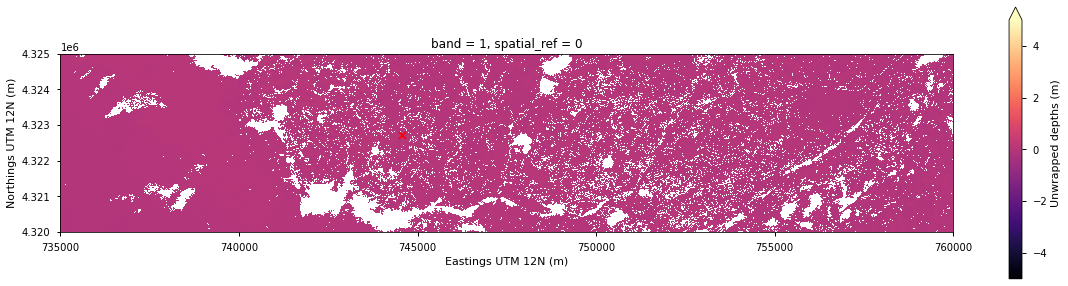

In [30]:
fig, ax = plt.subplots(figsize=(20,5)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the unwrapped depths
xds_delta_depth_hh_re.plot(cmap='magma', vmin=-5, vmax=5, ax=ax, 
                 cbar_kwargs={'label': 'Unwrapped depths (m)'})

# plot the location of the snow pit of interest
siteData_df.plot(ax=ax, color='r', marker='x')

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

# set the axes limits, units in meters UTM Zone 12N (I chose these values by just looking at the plot above)
ax.set_xlim((735000, 760000)) # x axis limits
ax.set_ylim((4320000, 4325000)) # y axis limits

# set plot title
#ax.set_title('Location of Snow Pit 2S10\nwith Airborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)');